In [1]:
!pip install --upgrade tensorflow-gpu==2.0

Requirement already up-to-date: tensorflow-gpu==2.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (2.0.0)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.tokenize import word_tokenize

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
%%time

input_data = 's3://osanusi-auto/preprocessed_frl_fake.csv'
news_df = pd.read_csv(input_data)
news_df.head()

CPU times: user 40 s, sys: 5.27 s, total: 45.3 s
Wall time: 2min 45s


,domain,content,scraped_at,title,label,day_name
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday
3,yahoo,beirut latest development syria backed kurdish...,2016-11-08 03:28:07.118000+00:00,latest turkey kurd naive,real,tuesday
4,sfgate,hotshooting tennessee tech rout alabama publis...,2016-11-18 22:38:10.550000+00:00,hotshooting tennessee tech rout alabama sfgate,real,friday


In [4]:
news_df.isnull().sum()

domain            0
content          18
scraped_at        0
title         12629
label             0
day_name          0
dtype: int64

In [5]:
news_df.dropna(inplace=True)
news_df.isnull().sum()

domain        0
content       0
scraped_at    0
title         0
label         0
day_name      0
dtype: int64

In [6]:
news_df.shape

(1775353, 6)

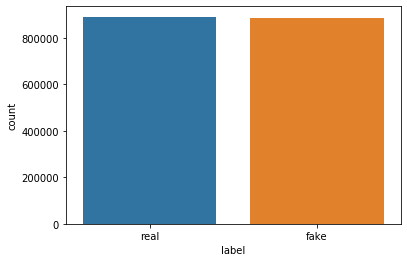

In [7]:
sns.countplot(x='label', data=news_df)

In [8]:
news_df['all_text'] = news_df['title'] + ' ' + news_df['content']
news_df.head()

,domain,content,scraped_at,title,label,day_name,all_text
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday,appeal challenge child month threejudge panel ...
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday,sweden seek assurance trump defense agreement ...
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday,brooklyn clash religious woman right week bus ...
3,yahoo,beirut latest development syria backed kurdish...,2016-11-08 03:28:07.118000+00:00,latest turkey kurd naive,real,tuesday,latest turkey kurd naive beirut latest develop...
4,sfgate,hotshooting tennessee tech rout alabama publis...,2016-11-18 22:38:10.550000+00:00,hotshooting tennessee tech rout alabama sfgate,real,friday,hotshooting tennessee tech rout alabama sfgate...


In [9]:
maxlen = -1
for doc in news_df.all_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 15595


In [10]:
news_df['all_words'] = news_df['all_text'].str.split()

In [11]:
news_df.head()

,domain,content,scraped_at,title,label,day_name,all_text,all_words
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday,appeal challenge child month threejudge panel ...,"[appeal, challenge, child, month, threejudge, ..."
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday,sweden seek assurance trump defense agreement ...,"[sweden, seek, assurance, trump, defense, agre..."
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday,brooklyn clash religious woman right week bus ...,"[brooklyn, clash, religious, woman, right, wee..."
3,yahoo,beirut latest development syria backed kurdish...,2016-11-08 03:28:07.118000+00:00,latest turkey kurd naive,real,tuesday,latest turkey kurd naive beirut latest develop...,"[latest, turkey, kurd, naive, beirut, latest, ..."
4,sfgate,hotshooting tennessee tech rout alabama publis...,2016-11-18 22:38:10.550000+00:00,hotshooting tennessee tech rout alabama sfgate,real,friday,hotshooting tennessee tech rout alabama sfgate...,"[hotshooting, tennessee, tech, rout, alabama, ..."


In [12]:
list_of_words = []
for i in news_df.all_words:
    for j in i:
        list_of_words.append(j)
        
list_of_words

['appeal',
 'challenge',
 'child',
 'month',
 'threejudge',
 'panel',
 'federal',
 'appeal',
 'court',
 'revived',
 'legal',
 'challenge',
 'federal',
 'child',
 'left',
 'education',
 'secretary',
 'margaret',
 'spelling',
 'said',
 'united',
 'state',
 'court',
 'appeal',
 'sixth',
 'circuit',
 'cincinnati',
 'convene',
 'larger',
 'panel',
 'reconsider',
 'ruling',
 'ruling',
 'sixth',
 'circuit',
 'said',
 'school',
 'district',
 'michigan',
 'state',
 'justified',
 'suit',
 'argued',
 'required',
 'testing',
 'program',
 'providing',
 'sufficient',
 'federal',
 'money',
 'sweden',
 'seek',
 'assurance',
 'trump',
 'defense',
 'agreement',
 'stockholm',
 'reuters',
 'sweden',
 'seek',
 'assurance',
 'presidentelect',
 'donald',
 'trump',
 'recently',
 'signed',
 'defense',
 'cooperation',
 'agreement',
 'honored',
 'administration',
 'commitment',
 'nato',
 'defence',
 'minister',
 'peter',
 'hultqvist',
 'said',
 'year',
 'rising',
 'tension',
 'russia',
 'baltic',
 'region',
 'sw

In [13]:
len(list_of_words)

401181785

In [14]:
total_words = len(list(set(list_of_words)))
total_words

2031000

In [15]:
dummy = pd.get_dummies(news_df['label'])
dummy.head()

,fake,real
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [16]:
news_df = pd.concat([news_df, dummy], axis=1)
news_df.head()

,domain,content,scraped_at,title,label,day_name,all_text,all_words,fake,real
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday,appeal challenge child month threejudge panel ...,"[appeal, challenge, child, month, threejudge, ...",0,1
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday,sweden seek assurance trump defense agreement ...,"[sweden, seek, assurance, trump, defense, agre...",0,1
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday,brooklyn clash religious woman right week bus ...,"[brooklyn, clash, religious, woman, right, wee...",0,1
3,yahoo,beirut latest development syria backed kurdish...,2016-11-08 03:28:07.118000+00:00,latest turkey kurd naive,real,tuesday,latest turkey kurd naive beirut latest develop...,"[latest, turkey, kurd, naive, beirut, latest, ...",0,1
4,sfgate,hotshooting tennessee tech rout alabama publis...,2016-11-18 22:38:10.550000+00:00,hotshooting tennessee tech rout alabama sfgate,real,friday,hotshooting tennessee tech rout alabama sfgate...,"[hotshooting, tennessee, tech, rout, alabama, ...",0,1


In [17]:
x_train, x_test, y_train, y_test = train_test_split(news_df.all_text, news_df.real, test_size = 0.2)

In [18]:
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [19]:
padded_train = pad_sequences(train_sequences, maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 40, truncating = 'post')

In [20]:
for i, doc in enumerate(padded_train[:2]):
    print('The padded encoding for document', i+1, ' is : ', doc )

The padded encoding for document 1  is :  [  1273    654    179    362   1531     18     23     83    511    180
    443   1501    124    361     18    606 889737   2146    461    587
 889738   8241    976      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]
The padded encoding for document 2  is :  [ 2376    22    79   557    22 13285  2376    22    79   557    22 13285
   834   119    52    22    79  1878   359  4306    22 13285   321     3
   400    68   836 29384  1396   338  5522    75   532  1229   325   755
   132   496    16   581]


In [21]:
model = Sequential()

In [22]:
model.add(Embedding(total_words, output_dim = 128))

model.add(Bidirectional(LSTM(128)))

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         259968000 
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 260,264,193
Trainable params: 260,264,193
Non-trainable params: 0
_________________________________________________________________


In [23]:
y_train = np.asarray(y_train)

In [ ]:
%%time

model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 4)

Train on 1278253 samples, validate on 142029 samples
Epoch 1/4
 885632/1278253 [===================>..........] - ETA: 4:49:21 - loss: 0.0998 - acc: 0.9629